Spacecraft model feed forward

In [17]:
import numpy as np
from scipy import interpolate
import pygmo as pg #https://esa.github.io/pagmo2/docs/python/tutorials/coding_udp_simple.html
import time
from itertools import product

In [2]:
toyear = 1/(3600*24*365)

In [3]:
μ = 3.986005e14 # m^3/s^2 standard gravitational parameter
R = 6378e3 # m
Q = 1367 # W/m^2
EN = 10
D_r = 5.3 # m
L = 9.772372209558107
k = 1.38064852e-23 # J/K Boltzman constant R/Na
T_s = 135 # K
B = 8 # bit
N = 2e3 # pixel width
η = 0.55
λ_v = 500e-9 # m
f = 2.2e9 # Hz
c = 2.998e8 # m/s
η_A = 0.29
ρ_A = 10 # kg/m^2
ρ_p = 100 # kg/m^1.5
ρ_T = 2 # kg/m^1.5
ρ_P = 500e3 # kg*m
ρ_b = 0.002e-3 # kg/J
P_l = 5 # W
m_c = 0.2 # kg required weight
η_S = 0.2 # 20% of total mass is structural mass
C_D = 2.2 # coefficient of drag
G = 9.81 # m/s^2 gravitational constant
I_sp = 70 # s impulse specific constant
w_W = 1000 # radians/s for maximum angular velocity of reaction wheel
c_W = 1 # constant to make gravity gradient significant enough to count
ρ_M = 11e4  # MTQ
ρ_P2 = 9/0.1 # acs
M_B = 7.96e15
m_c = 0.2
κ=0.00002

Data tables

In [116]:
h_ρi = np.array([100, 150, 200, 250, 300, 350, 400, 450, 500, 
                 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1250, 1500])*1e3
ρi = np.array([4.79e-07, 1.81e-09, 2.53e-10, 6.24e-11, 1.95e-11, 6.98e-12, 2.72e-12, 
               1.13e-12, 4.89e-13, 2.21e-13, 1.04e-13, 5.15e-14, 2.72e-14, 1.55e-14, 
               9.63e-15, 6.47e-15, 4.66e-15, 3.54e-15, 2.79e-15, 1.11e-15, 5.21e-16])
Hi = np.array([5.9, 25.5, 37.5, 44.8, 50.3, 54.8, 58.2, 61.3, 64.5, 68.7, 74.8, 84.4, 
               99.3, 121, 151, 188, 226, 263, 296, 408, 516])*1e3
ρinterp = interpolate.interp1d(h_ρi, ρi)
Hinterp = interpolate.interp1d(h_ρi, Hi)
ρ = lambda h: ρinterp(h) if h <= 1500e3 else 5.21e-16
H = lambda h: Hinterp(h) if h <= 1500e3 else 516e3

In [117]:
λ_c = c/f
G_r = η*(np.pi*D_r/λ_c)**2

In [118]:
L_min = 3
X_r = 10 # m

In [119]:
dBtoLinear = lambda db: 10**(db/10)
n_T = 2 # transmitter catalog
m_Ti = [0.053, 0.300]
P_Ti = [10, 10]
G_Ti = [dBtoLinear(10), dBtoLinear(16.5)]

n_b = 5 # battery catalog
E_bi = [138600, 144000, 144000, 165600, 1607040]
m_bi = [0.270, 0.310, 0.355, 0.710, 3.95]

n_p = 3 # payload catalog
D_pi = [0.025, 0.075, 0.1]
m_pi = [0.080, 1.75, 3.0]

n_A = 2 # solar panel catalog
ρ_Ai = [5.35, 0.84]
η_Ai = [0.305, 0.275]

In [124]:
g1 = lambda d, A, η_A, P_T: d*A*η_A*Q-P_T # positive
g2 = lambda E_b, d, T, P_T: E_b-1/d*P_T*T
def g3(T, P_T, G_T, r):
    D = 2*np.pi*R*B*N/X_r
    b = D/T
    #print(b/(8*1e6)) #Mb/s
    #D_T = λ_c*np.sqrt(G_T/η)/np.pi
    EN_calc = P_T*G_r*G_T/(L*k*T_s*b)*(λ_c/(4*np.pi*r))**2
    return 10*np.log10(EN_calc)-EN
def f4(a, T, A, ρ_A, m_s, m_T, m_p, m_b, m_pr, choice):
    T_g = 3*μ/(2*a**3)*c_W
    if choice:
        m_torque = ρ_P2*T*T_g*1/4*np.sqrt(2)/2*3*365*L_min/(G*I_sp)
    else:
        m_torque = ρ_M*T_g
    m_A=ρ_A*A
    return m_s+m_T+m_c+m_A+m_p+m_b+m_torque+m_pr
def g4(h, a, A, T, mt, m_pr):
    Ln = H(h)*mt/(2*np.pi*C_D*A*ρ(h)*a**2)*T
    Lp = m_pr*I_sp*G*a/(0.5*C_D*A*ρ(h)*μ)
    #print(Ln*toyear, Lp*toyear)
    return (Ln+Lp)*toyear-L_min
h5 = lambda ms, mt: ms - η_S*mt

In [125]:
#xc = [500e3, 0.05, 0.5, 0.25]
xd = [0,0,0,0,0]

In [128]:
class my_constrained_udp:
    def __init__(self, xd):
        self.xd = xd
        
    def fitness(self, x):
        comms, bat, payload, solar, choice = self.xd
        A, m_s, m_pr = x
        #print(x)
        m_T, P_T, G_T = m_Ti[comms], P_Ti[comms], G_Ti[comms]
        E_b, m_b = E_bi[bat], m_bi[bat]
        D_p, m_p = D_pi[payload], m_pi[payload]
        ρ_A, η_A = ρ_Ai[solar], η_Ai[solar]
        h = X_r*D_p/(1.22*λ_v)
        #print(h)
        a = h + R
        T = 2*np.pi*np.sqrt(a**3/μ)
        g = 1/np.pi*np.arccos(R/(R+h))
        d = g+0.5
        r = np.sqrt(h**2+2*R*h)
        mt = f4(a, T, A, ρ_A, m_s, m_T, m_p, m_b, m_pr, choice)
        ce1 = h5(m_s, mt)
        ci1 = g1(d, A, η_A, P_T)
        ci2 = g2(E_b, d, T, P_T)
        ci3 = g3(T, P_T, G_T, r)
        ci4 = g4(h, a, A, T, mt, m_pr)
        return [mt, ce1, -ci1, -ci2, -ci3, -ci4]
    def get_bounds(self):
        return ([0.001,1e-6,1e-6],[1, 20, 20])
    def get_nic(self):
        return 4
    def get_nec(self):
        return 1
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)

In [129]:
#prob = pg.problem(my_constrained_udp(xd))
#algo = pg.algorithm(uda = pg.nlopt('auglag'))
#algo.extract(pg.nlopt).local_optimizer = pg.nlopt('var2')
algo = pg.algorithm(uda = pg.mbh(pg.nlopt("slsqp"), stop = 20, perturb = .2))
algo.set_verbosity(1)
pop = pg.population(prob = my_constrained_udp(xd), size = 1)
pop.problem.c_tol = [1E-6] * 5

In [130]:
fsols[0]

array([ 1.27905839e+00, -3.62820884e-13,  2.23980834e-11, -4.75371824e+04,
       -9.30842529e+00, -8.94187971e+03])

In [131]:
my_constrained_udp((0, 0, 0, 0, 0)).fitness(xsols[0])

[1.2790583858976698,
 -3.6282088444750116e-13,
 2.2398083387997758e-11,
 -47537.18237468571,
 -9.30842529444924,
 2.779349875124935]

In [132]:
%%time
xsols = []
fsols = []
c = 0
for xd in product(range(2),range(5),range(3),range(2),range(2)):
    c+=1
    #if c>=5:
    #    break
    start_time = time.time();
    #print(xd)
    pop = pg.population(prob = my_constrained_udp(xd), size = 1)
    pop.problem.c_tol = [1E-6] * 5
    pop = algo.evolve(pop)
    print(c, time.time()-start_time)
    fsols.append(pop.champion_f)
    xsols.append(pop.champion_x)

1 2.500096559524536
2 1.4129753112792969
3 2.11887526512146
4 1.9449968338012695
5 1.1564772129058838
6 1.9773845672607422
7 1.396683692932129
8 2.0922725200653076
9 0.5550000667572021
10 0.5268394947052002
11 0.3914668560028076
12 0.6620793342590332
13 3.3981516361236572
14 1.984867811203003
15 4.273959159851074
16 3.0017879009246826
17 0.9765229225158691
18 1.1190063953399658
19 1.8505480289459229
20 1.4687366485595703
21 0.8331568241119385
22 0.7279818058013916
23 0.3574090003967285
24 1.0689995288848877
25 1.9401764869689941
26 1.8996880054473877
27 1.3202228546142578
28 3.6641809940338135
29 0.9481165409088135
30 0.8861417770385742
31 0.8714468479156494
32 1.276047945022583
33 0.3599984645843506
34 0.669996976852417
35 0.46999645233154297
36 0.5089981555938721
37 1.9120545387268066
38 3.0700035095214844
39 1.6890976428985596
40 1.7212235927581787
41 2.2996103763580322
42 2.8872451782226562
43 1.2530388832092285
44 1.6750602722167969
45 0.5871138572692871
46 0.4979984760284424
47 0

In [135]:
import matplotlib.pyplot as plt

In [136]:
masses = [f[0] for f in fsols]

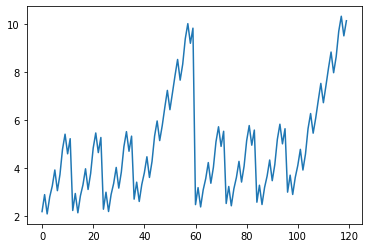

In [137]:
plt.plot(masses)

In [139]:
np.argmin(masses)

2

In [140]:
comms, bat, payload, solar, choice = list(product(range(2),range(5),range(3),range(2),range(2)))[2]

In [141]:
comms, bat, payload, solar, choice

(0, 0, 0, 1, 0)

In [142]:
xsols[2]

array([0.04352431, 0.42017571, 0.83084799])

In [143]:
my_constrained_udp([comms, bat, payload, solar, choice]).fitness(xsols[2])

[2.1008785341437193,
 1.1324274851176597e-14,
 -1.9628642533575658e-07,
 -47537.18237468571,
 -9.30842529444924,
 9.142718475629863e-07]

In [109]:
m_T, P_T, G_T = m_Ti[comms], P_Ti[comms], G_Ti[comms]
E_b, m_b = E_bi[bat], m_bi[bat]
D_p, m_p = D_pi[payload], m_pi[payload]
ρ_A, η_A = ρ_Ai[solar], η_Ai[solar]

In [73]:
pop.champion_f

array([ 1.15959309e+00, -4.99186831e-09,  4.84181536e-07, -4.02279227e+04,
       -3.29598711e+00, -1.21676326e+04])

In [37]:
pop.champion_x

array([6.16288433e+02, 5.09874120e-01, 6.07571482e+01, 3.33637451e+01])

In [315]:
def eval_all(xd, xc):
    comms, bat, payload, solar, choice = xd
    m_T, P_T, G_T = m_Ti[comms], P_Ti[comms], G_Ti[comms]
    E_b, m_b = E_bi[bat], m_bi[bat]
    D_p, m_p = D_pi[payload], m_pi[payload]
    ρ_A, η_A = ρ_Ai[solar], η_Ai[solar]
    h, A, m_s, m_pr = xc
    a = h + R
    T = 2*np.pi*np.sqrt(a**3/μ)
    g = 1/np.pi*np.arccos(R/(R+h))
    d = g+0.5
    r = np.sqrt(h**2+2*R*h)
    mt = f4(a, T, A, ρ_A, m_s, m_T, m_p, m_b, choice)

In [308]:
a = h + R
T = 2*np.pi*np.sqrt(a**3/μ)
g = 1/np.pi*np.arccos(R/(R+h))
d = g+0.5
r = np.sqrt(h**2+2*R*h)

In [309]:
g1 = lambda A, η_A, P_T: d*A*η_A*Q-P_T # positive
g1(A, η_A, P_T)

2.9691740677017098

In [310]:
g2 = lambda E_b, d, T, P_T: E_b-1/d*P_T*T
g2(E_b, d, T, P_T)

47350.55219091913

In [311]:
def g3(T, P_T):
    D = 2*np.pi*R*B*N/X_r
    b = D/T
    #print(b/(8*1e6)) #Mb/s
    #D_T = λ_c*np.sqrt(G_T/η)/np.pi
    EN_calc = P_T*G_r*G_T/(L*k*T_s*b)*(λ_c/(4*np.pi*r))**2
    return 10*np.log10(EN_calc)-EN
g3(T, P_T)

7.251761495956831

In [322]:
def f4(a, T, A, ρ_A, m_s, m_T, m_p, m_b):
    T_g = 3*μ/(2*a**3)*c_W
    if choice:
        m_torque = ρ_P2*T*T_g*1/4*np.sqrt(2)/2*3*365*L_min/(G*I_sp)
    else:
        m_torque = ρ_M*T_g
    m_A=ρ_A*A
    return m_s+m_T+m_c+m_A+m_p+m_b+m_torque
mt = f4(a, T, A, ρ_A, m_s, m_T, m_p, m_b)

In [327]:
def g4(h, a, A, T, mt, m_pr):
    Ln = H(h)*mt/(2*np.pi*C_D*A*ρ(h)*a**2)*T
    Lp = m_pr*I_sp*G*a/(0.5*C_D*A*ρ(h)*μ)
    #print(Ln*toyear, Lp*toyear)
    return (Ln+Lp)*toyear-L_min

In [328]:
h5 = lambda ms, mt: ms - η_S*mt

In [279]:
m = 0.2678
print(round(m*70*9.81))
print(round(70*9.81*np.log(3/(3-m))))
print(round(70*9.81*np.log(4/(4-m))))s

184
64.0
48.0


In [224]:
m = 1
A = 0.01
h = 400e3
a = R+h
T = 2*np.pi*np.sqrt(a**3/μ)
H(h)*m/(2*np.pi*C_D*A*ρ(h)*a**2)*4000*toyear

0.42736778981994905

In [326]:
g4(h, a, A, T, mt, m_pr)

1.5717926672129576 3.492635249842361


2.064427917055319